In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
# Hyperparameter
batch_size = 64
z_dim = 128
f_dim = 10
learning_rate_gen = 5e-5
learning_rate_dis = 5e-5
max_step = 20000
n_dis = 5
# lambda (gradient panelty)
lam = 10.

In [0]:
# Define Generator Network
def generator(x, label, reuse = False):
    with tf.variable_scope('generator', reuse = reuse):
      
        x = tf.concat([x, label], axis = 1)
        
        fc1 = tf.layers.dense(x, 
                              units = 5 * 5 * 256, 
                              activation = tf.nn.leaky_relu)
        fc1 = tf.layers.batch_normalization(fc1)
        fc1 = tf.reshape(fc1, [-1, 5, 5, 256])

        # First Convolutional Layer
        conv1 = tf.layers.conv2d_transpose(fc1, 
                                           filters = 128, 
                                           kernel_size = 5,
                                           strides = 2,
                                           activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)

        # Second Convolutional Layer
        conv2 = tf.layers.conv2d(conv1, 
                                 filters = 128, 
                                 kernel_size = 3, 
                                 padding = 'same',
                                 activation = tf.nn.leaky_relu)
        conv2 = tf.layers.batch_normalization(conv2)


        # Third Convolutional Layer (Output Layer with tanh activation)
        output = tf.layers.conv2d_transpose(conv2, 
                                            filters = 1, 
                                            kernel_size = 4, 
                                            strides = 2,
                                            activation = tf.nn.tanh)
        
        return output

In [0]:
# Define Discriminator Network
def discriminator(x, label, reuse = False):
    with tf.variable_scope('discriminator', reuse = reuse):
        # First Convolutional Layer
        conv1 = tf.layers.conv2d(x, 
                                 filters = 256, 
                                 kernel_size = 4, 
                                 strides = 2,
                                 activation = tf.nn.leaky_relu)
        conv1 = tf.layers.batch_normalization(conv1)
        
        conv2 = tf.layers.conv2d(conv1, 
                                 filters = 128, 
                                 kernel_size = 3, 
                                 strides = 1, 
                                 padding = 'same', 
                                 activation = tf.nn.leaky_relu)
        
        conv2 = tf.layers.batch_normalization(conv2, momentum = 0.9)
        
        output = tf.layers.flatten(conv2)
        
        output = tf.concat([output, label], axis = 1)
        
        output = tf.layers.dense(output, 
                                 units = 20,
                                 activation = tf.nn.relu)
        
        output = tf.layers.dense(output, 
                                 units = 1)
        return output

In [0]:
# Input
gen_input = tf.placeholder(tf.float32, shape = [None, z_dim - f_dim], name = 'gen_input')
dis_input = tf.placeholder(tf.float32, shape = [None, 28, 28, 1], name = 'dis_input')
label_input = tf.placeholder(tf.float32, shape = [None, f_dim], name = 'label')
fake_input = generator(gen_input, label_input)

# Logits
true_logit = discriminator(dis_input, label_input)
fake_logit = discriminator(fake_input, label_input, reuse = True)
dis_loss = tf.reduce_mean(fake_logit - true_logit)
gen_loss = tf.reduce_mean(- fake_logit)

# Variables
gen_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
dis_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')

## Gradient Penalty

# Generate Interpolated Samples
uniform_dist = tf.contrib.distributions.Uniform(low=0., high=1.)
alpha = uniform_dist.sample((batch_size, 1, 1, 1))
interpolated = dis_input + alpha * (fake_input - dis_input)

# Calculate Gradients
int_logit = discriminator(interpolated, label_input, reuse = True)
gradients = tf.gradients(int_logit, [interpolated, ])[0]
gradients_l2 = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis = [1, 2, 3]))

# Panelty
gradient_penalty = lam * tf.reduce_mean((gradients_l2 - 1) ** 2)
dis_loss += gradient_penalty

# Optimizer (RMSProp)
gen_opt = tf.train.RMSPropOptimizer(learning_rate_gen).minimize(gen_loss, var_list = gen_var)
dis_opt = tf.train.RMSPropOptimizer(learning_rate_dis).minimize(dis_loss, var_list = dis_var)

# Initialization
init = tf.global_variables_initializer()

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(max_step):
    
    for j in range(n_dis):
        batch_x, batch_label = mnist.train.next_batch(batch_size)
        batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
        z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
        feed_dict = {gen_input: z, dis_input: batch_x, label_input: batch_label}
        sess.run([dis_opt], feed_dict = feed_dict)
        
    batch_x, batch_label = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    z = np.random.normal(0., 1., size=[batch_size, z_dim - f_dim])
    feed_dict = {gen_input: z, dis_input: batch_x, label_input: batch_label}
    _, d_loss, g_loss, p = sess.run([gen_opt, dis_loss, gen_loss, gradient_penalty], feed_dict = feed_dict)
    if i % 200 == 0:
        print ('step {}: {}, {}, {}'.format(i, d_loss, g_loss, p))

step 0: 8.83051872253418, 0.015505618415772915, 8.80695915222168
step 200: -6.798028469085693, 5.723103046417236, 1.2193244695663452
step 400: -5.1186723709106445, 4.984966278076172, 0.5425372123718262
step 600: -4.356755256652832, 3.967428207397461, 0.47272539138793945
step 800: -3.7805280685424805, 6.777619361877441, 0.32525622844696045
step 1000: -3.076136589050293, 9.924583435058594, 0.28345274925231934
step 1200: -2.7891647815704346, 10.37491226196289, 0.3571813702583313
step 1400: -2.891592025756836, 10.852174758911133, 0.3606095314025879
step 1600: -2.8209216594696045, 12.385688781738281, 0.3004853129386902
step 1800: -2.4115898609161377, 12.428430557250977, 0.33037298917770386
step 2000: -2.359282970428467, 13.171091079711914, 0.23211386799812317
step 2200: -2.332183599472046, 14.15202522277832, 0.19656744599342346
step 2400: -2.232194185256958, 15.832986831665039, 0.21963194012641907
step 2600: -2.1922149658203125, 14.812965393066406, 0.23636925220489502
step 2800: -1.90023827

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


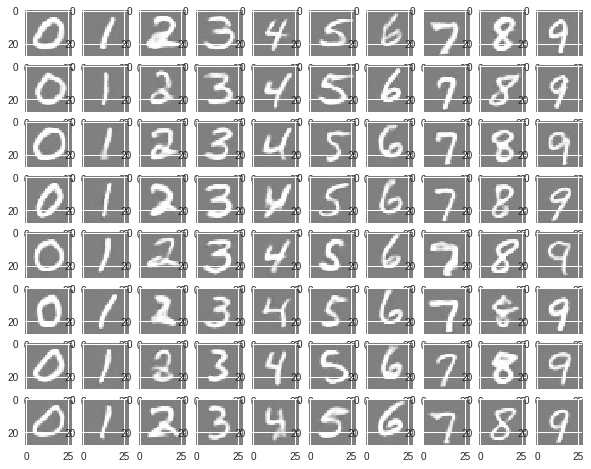

In [8]:
# Generate images from noise, using the generator network.
f, a = plt.subplots(8, 10, figsize=(10, 8))
for i in range(8):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[10, z_dim - f_dim])
    batch_label = np.zeros((10, f_dim))
    for j in range(10):
        batch_label[j][j] = 1.
    g = sess.run(fake_input, feed_dict={gen_input: z, label_input: batch_label})
    g = (g + 1) / 2
    for j in range(10):
        # Generate image from noise. Extend to 3 channels for matplot figure.
        img = np.reshape(np.repeat(g[j][:, :, np.newaxis], 3, axis=2),
                         newshape=(28, 28, 3))
        a[i][j].imshow(img)

f.show()
plt.draw()